Read in all data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from utils import stratified_sample, annotate, even_train_split
import glob  # Importing the glob module to find all the files matching a pattern

# Pattern to match the data files
file_pattern = "data_files/user_*/metric_df.csv"

# Initialize a dictionary to store one_user_one_user_dataframes for each dataset
all_datasets = {}

# Loop through each file that matches the file pattern
for filepath in glob.glob(file_pattern):
    # print(filepath)
    # print(filepath.split('/'))
    user_name = filepath.split('/')[1]
    # user_name = filepath.split('\\')[1]
    print(f"Processing {filepath} dataset...")

    # Read in data file as a pandas dataframe
    data = pd.read_csv(filepath, index_col=0)

    # add weighted performance metric
    w = 1
    data["total_error"] = data['avg_osd'] + data['avg_target_error']
    data["weighted_performance"] = 10*data['throughput'] - w*data["total_error"]

    all_datasets[user_name] = data

# Combine datasets for Lizzie
lizzie1 = all_datasets["user_lizzie1"]
lizzie2 = all_datasets["user_lizzie2"]
combined_df = pd.concat([lizzie1, lizzie2])
all_datasets["user_lizzie"] = combined_df.groupby(['latency', 'scale']).mean().reset_index()

Processing data_files/user_jason/metric_df.csv dataset...
Processing data_files/user_lauren/metric_df.csv dataset...
Processing data_files/user_lizzie1/metric_df.csv dataset...
Processing data_files/user_lizzie2/metric_df.csv dataset...
Processing data_files/user_sarah1/metric_df.csv dataset...
Processing data_files/user_shreya/metric_df.csv dataset...
Processing data_files/user_sujaan/metric_df.csv dataset...
Processing data_files/user_xiao/metric_df.csv dataset...
Processing data_files/user_yutong/metric_df.csv dataset...


Modeling

In [ ]:
from models import PolyRegression, GPRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, RationalQuadratic, WhiteKernel
import utils
import json
import warnings
import logging

## Choose model to apply, returning predictions over original dataset and dense inputs
model_type = "Poly2"
# model_type = "GPR_RBF_default"
# model_type = "GPR_RBF_anisotropic"
# model_type = "GPR_RBF_Noise_default"
# model_type = "GPR_RBF_Noise_anisotropic"
# model_type = "GPR_RQ_default"
# model_type = "GPR_RQ_Noise_default"
# model_type = "blah"

# Configure logging to write to a file
logging.basicConfig(filename='warnings_log.txt', level=logging.WARNING, format='%(message)s')

# Function to redirect warnings to logging
def warn_to_logging(message, category, filename, lineno, file=None, line=None):
    logging.warning(f'{filename}:{lineno}: {category.__name__}: {message}')

# Redirect all warnings to the warn_to_logging function
warnings.showwarning = warn_to_logging

all_results = {}
output_metrics = ["throughput", "avg_target_error", "avg_osd", "avg_movement_speed", "total_error", "weighted_performance"]
for output_metric in output_metrics:
	
	print(output_metric)
	user_results = {}
	for user, data in list(all_datasets.items()): 
		# if user == "user_lizzie" or user == "user_lizzie1":
		# 	continue
		print(f"\t{user}")

		# Prepare data 
		X = data[['latency', 'scale']]
		Y = data[output_metric]

		# Initialize evaluation metrics
		optimal_match_rate = []
		optimal_scale_error = []
		mse_scores = []
		full_mse_scores = []
		n_train_mse = []
		n_train_full_mse = []
		n_train_p = []

		n = len(data)
		n_train_values = range(2, n-1)
		for n_train in n_train_values:

			n_train_p.append(n_train / n)
			# Split into training/test sets
			# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=n_train/n)
			train_set, test_set = even_train_split(data, n_train)
			X_train, X_test = train_set[['latency', 'scale']], test_set[['latency', 'scale']]
			Y_train, Y_test = train_set[output_metric], test_set[output_metric]
			
			# Create dense test input
			# latency_set = data['latency'].unique()# np.arange(0.0, 0.76, 0.01)
			# latency_range = np.array(data['latency'].unique()) #np.linspace(latency_set.min(), latency_set.max(), 50)
			latency_range = np.arange(0.0, data['latency'].max()+0.01, 0.01)
			scale_range = np.arange(data['scale'].min(), data['scale'].max()+0.025, 0.025) #np.linspace(data['scale'].min(), data['scale'].max(), 50)
			latency_grid, scale_grid = np.meshgrid(latency_range, scale_range)
			X_dense = np.c_[latency_grid.ravel(), scale_grid.ravel()]
			X_dense = np.round(X_dense, 3)
			
			# # Polynomial Regression
			if model_type.startswith("Poly"):
				degree = int(model_type.strip("Poly"))
				Y_pred, model_params = PolyRegression(X_train.values, Y_train.values, X.values, degree)
				Y_pred_dense, _ = PolyRegression(X_train.values, Y_train.values, X_dense, degree)

			# Gaussian Process Regression
			elif model_type.startswith("GPR"):
				# Choose kernel
				kernel_type = model_type.removeprefix("GPR_")
				# print(kernel_type)
				if kernel_type == "RBF_Noise_default":
					kernel = ConstantKernel() * RBF() + WhiteKernel() # Default RBF with likelihood noise
				elif kernel_type == "RBF_anisotropic":
					kernel = ConstantKernel() * RBF([1.0, 1.0])
				elif kernel_type == "RBF_Noise_anisotropic":
					kernel = ConstantKernel() * RBF([1.0, 1.0]) + WhiteKernel() # RBF with anistropic length scale
				elif kernel_type == "RQ_Noise_default":
					kernel = ConstantKernel() * RationalQuadratic() + WhiteKernel() # Default Rational Quadratic with likelihood noise
				else:
					print("Invalid kernel specification!")
					break
				
				Y_pred, Y_pred_std, model_params = GPRegression(X_train.values, Y_train.values, X.values, kernel)
				Y_pred_dense, Y_pred_std, _ = GPRegression(X_train.values, Y_train.values, X_dense, kernel)

			else:
				print("Invalid model type specification!")
				break

			## Evaluate metrics
			dense_df = pd.DataFrame({
					'latency': X_dense[:, 0].flatten(),
					'scale': X_dense[:, 1].flatten(),
					'Y_pred_dense': Y_pred_dense.flatten()
				})
			data["Y_pred"] = Y_pred

			# Mean Square Error on whole dataset
			full_mse = mean_squared_error(Y, Y_pred)
			if True: #full_mse < 5000:
				n_train_full_mse.append(n_train)
				full_mse_scores.append(full_mse)

			# Mean Square Error on test set
			Y_test_pred = data.loc[Y_test.index]["Y_pred"]
			mse = mean_squared_error(Y_test, Y_test_pred)
			if True: #mse < 5000:
				n_train_mse.append(n_train)
				mse_scores.append(mse)
			
			if output_metric in ["throughput", "avg_movement_speed", "weighted_performance"]: # optimal scale at maximum
				optimal_scale_dense = dense_df.loc[dense_df.groupby('latency')['Y_pred_dense'].idxmax()][['latency', 'scale']]
				optimal_scale_ref = data.loc[data.groupby('latency')[output_metric].idxmax()][['latency', 'scale']]
				optimal_scale_pred = data.loc[data.groupby('latency')['Y_pred'].idxmax()][['latency', 'scale']]
			else: # optimal scale at minimum
				optimal_scale_dense = dense_df.loc[dense_df.groupby('latency')['Y_pred_dense'].idxmin()][['latency', 'scale']]
				optimal_scale_ref = data.loc[data.groupby('latency')[output_metric].idxmin()][['latency', 'scale']]
				optimal_scale_pred = data.loc[data.groupby('latency')['Y_pred'].idxmin()][['latency', 'scale']]

			# Merge the results on 'latency'
			merged_ref_pred = pd.merge(optimal_scale_ref, optimal_scale_pred, 
								on='latency', suffixes=('_ref', '_pred'))
			
			merged_ref_dense = pd.merge(optimal_scale_ref, optimal_scale_dense, 
								on='latency', suffixes=('_ref', '_dense'))
			# print(optimal_scale_dense)
			# print(merged_ref_dense)
			

			# Count the number of matches
			matches = (merged_ref_pred['scale_ref'] == merged_ref_pred['scale_pred']).sum()
			scale_error = np.abs(merged_ref_dense['scale_ref'] - merged_ref_dense['scale_dense']).mean()

			optimal_match_rate.append(matches / len(optimal_scale_ref))
			optimal_scale_error.append(scale_error)

			# Visualize model prediction
			if n_train == n-2:
				utils.model_heatmaps(data, dense_df, X_train, user, output_metric, model_type, model_params)

		else:
			# Store results from this dataset
			user_results[user] = {
				'n_train_mse': list(n_train_mse),
				'n_train_full_mse': list(n_train_full_mse),
				'full_mse_scores': full_mse_scores,
				'mse_scores': mse_scores,
				'n_train_all': list(n_train_values),
				'match_rate': optimal_match_rate,
				'scale_error': optimal_scale_error,
				'n_train_p': n_train_p
			}
			continue
		break	
	else:
		all_results[output_metric] = user_results
		continue
	break

# print(all_results.keys())
with open(f"model_result_data/{model_type}.json", "w") as file:
	json.dump(all_results, file)
# with open(f"model_result_data/{model_type}.json", "r") as file:
# 	og_results = json.load(file)

# og_results["total_error"] = all_results["total_error"]

# with open(f"model_result_data/{model_type}.json", "w") as file:
# 	json.dump(og_results, file)



Visualize

In [ ]:
# # Plotting the results for all datasets
import matplotlib.pyplot as plt

# Load data
## Choose model to apply, returning predictions over original dataset and dense inputs
model_type = "Poly2"
# model_type = "GPR_RBF_default"
# model_type = "GPR_RBF_anisotropic"
# model_type = "GPR_RBF_Noise_default"
# model_type = "GPR_RBF_Noise_anisotropic"
# model_type = "GPR_RQ_default"
# model_type = "GPR_RQ_Noise_default"
# model_type = "blah"

with open(f"model_result_data/{model_type}.json", "r") as file:
	all_results = json.load(file)

for output_metric, user_results in all_results.items():

	fig, axes = plt.subplots(2, 2, figsize=(16, 8))
	fig.suptitle(f"Model Evaluation Metrics for {model_type} predicting {output_metric}")
	for user, results in user_results.items():
		axes[0, 0].plot(results['n_train_p'], results['match_rate'], marker='o', label=user)
		axes[0, 1].plot(results['n_train_p'], results['scale_error'], marker='o', label=user)
		axes[1, 0].plot(results['n_train_p'], results['full_mse_scores'], marker='o', label=user)
		axes[1, 1].plot(results['n_train_p'], results['mse_scores'], marker='o', label=user)

	axes[0, 0].set_title("Optimal Scale Prediction Rate")
	axes[0, 0].set_xlabel("Training Set Proportion")
	axes[0, 0].set_ylabel("Percentage of Correct Predictions")

	axes[0, 1].set_title("Optimal Scale Prediction Error Using Dense Prediction")
	axes[0, 1].set_xlabel("Training Set Proportion")
	axes[0, 1].set_ylabel("Avg Error")


	axes[1, 0].set_title('MSE on whole dataset')
	axes[1, 0].set_xlabel('Training Set Proportion')
	axes[1, 0].set_ylabel('Model Accuracy (MSE Score)')

	axes[1, 1].set_title('MSE on test set')
	axes[1, 1].set_xlabel('Training Set Proportion')
	axes[1, 1].set_ylabel('Model Accuracy (MSE Score)')
	axes[1, 0].legend()

	plt.tight_layout()
	plt.savefig(f"figures/model_results/{output_metric}/{model_type}_model_eval_metrics_{output_metric}.png", facecolor='w')
	plt.show()


{'throughput': {'user_jason': {'n_train_mse': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], 'n_train_full_mse': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], 'full_mse_scores': [0.910064999207969, 0.9198223820630609, 0.9150531643287364, 0.97514703128062, 0.7076574482515247, 0.7200610642027486, 0.7247274813334094, 0.8268400552490581, 0.675655093586182, 0.6688995923624408, 0.7225296102405203, 0.7142348882167656, 0.6158555963198141, 0.6164925880807847, 0.6448784455697372, 0.6854484854313894, 0.6066456291140917, 0.5919413271349772, 0.607907406751424, 0.6184147790382093, 0.5764897598920143, 0.5746821737598704, 0.5890495495035647, 0.5961112664136581, 0.5724710482454858], 'mse_scores': [0.9641984115936346, 1.0125451693814709, 1.047372788363074, 1.1493740627496964, 0.7008716746131292, 0.6129315862514231, 0.6508254459414134, 0.9956670438812817, 0.6988863862694976, 0.7197476709315282, 0.88903376246832

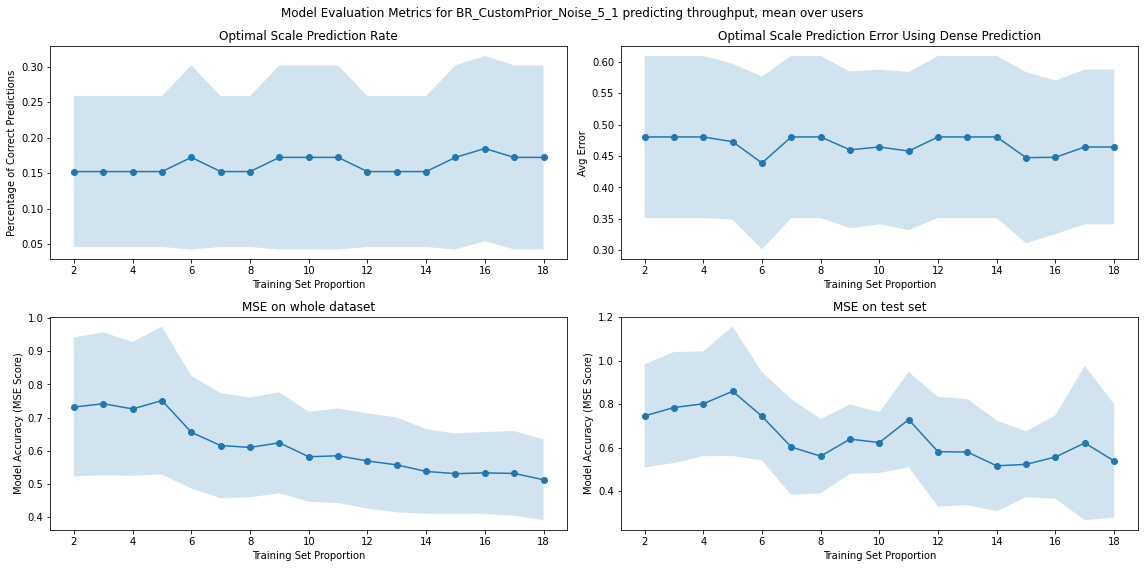

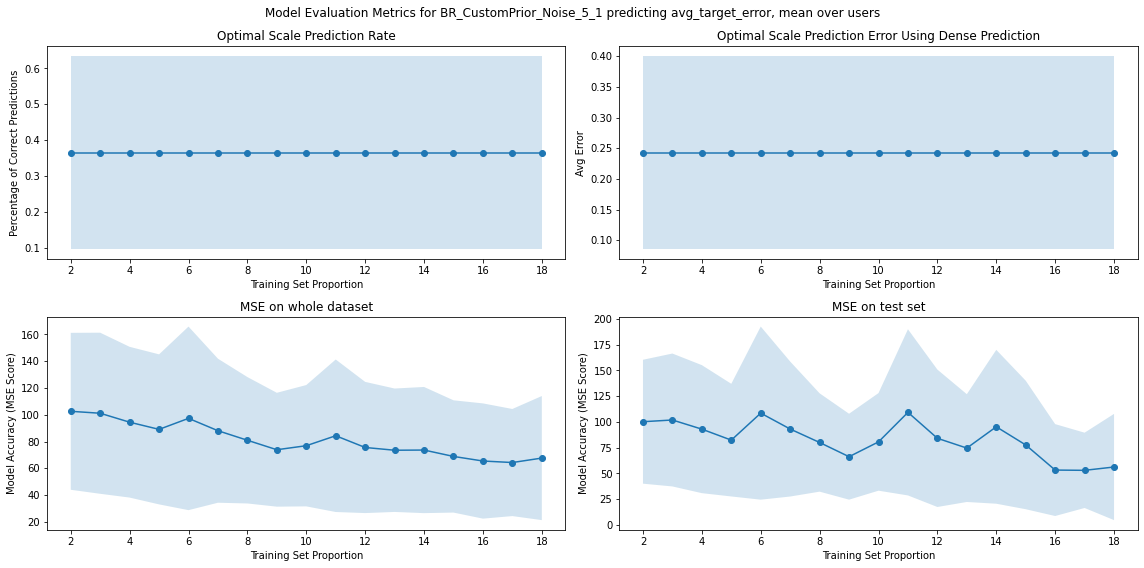

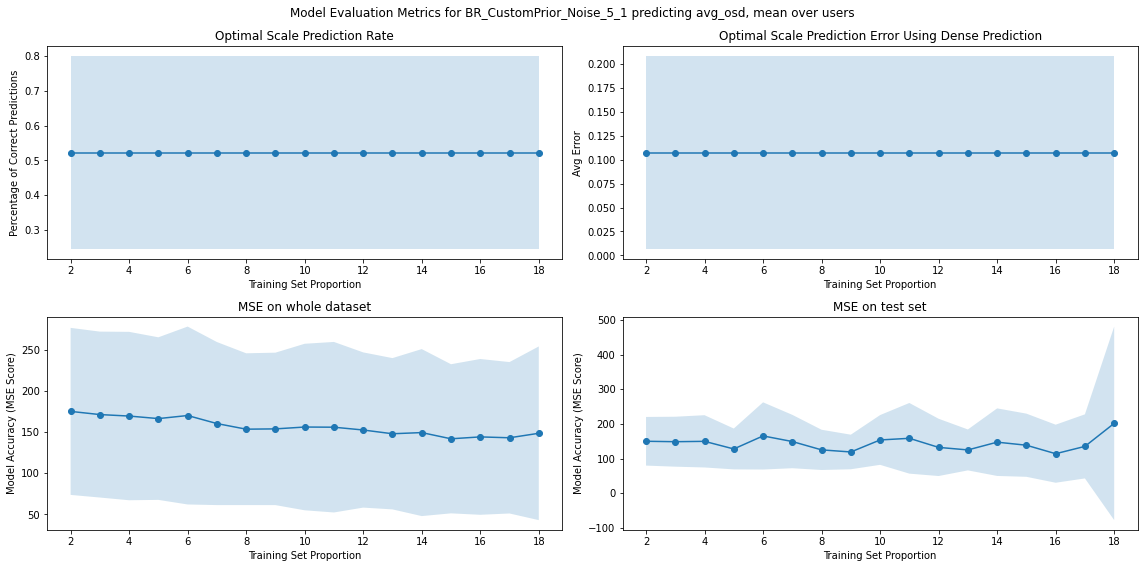

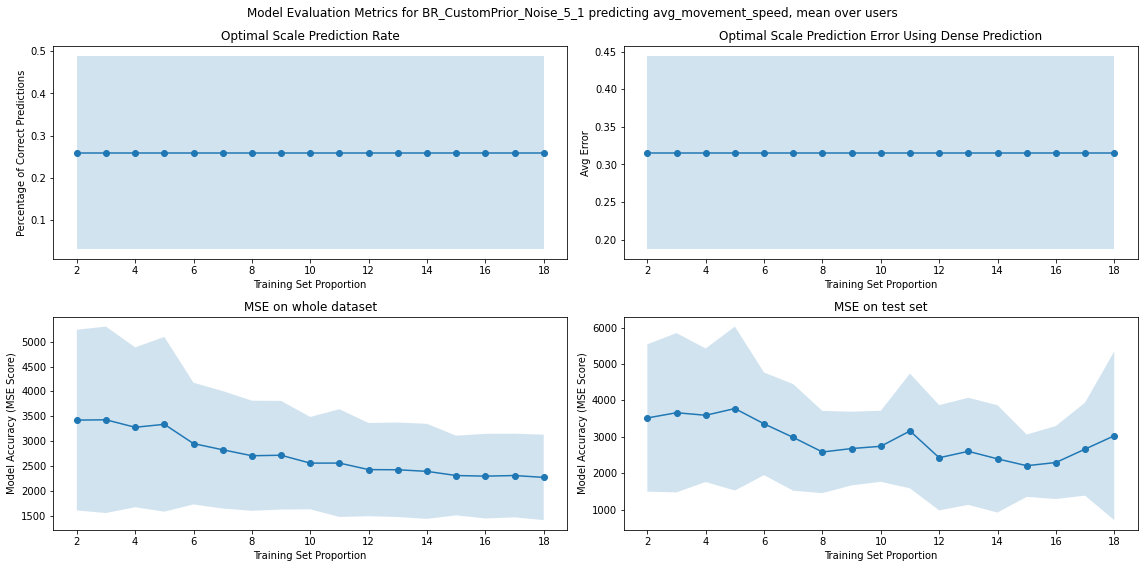

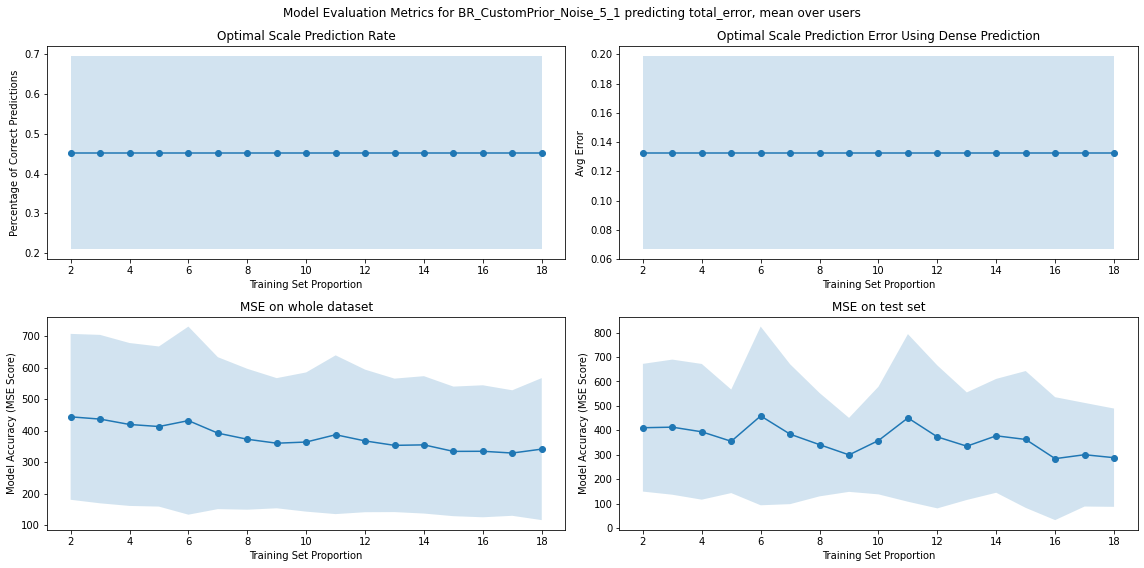

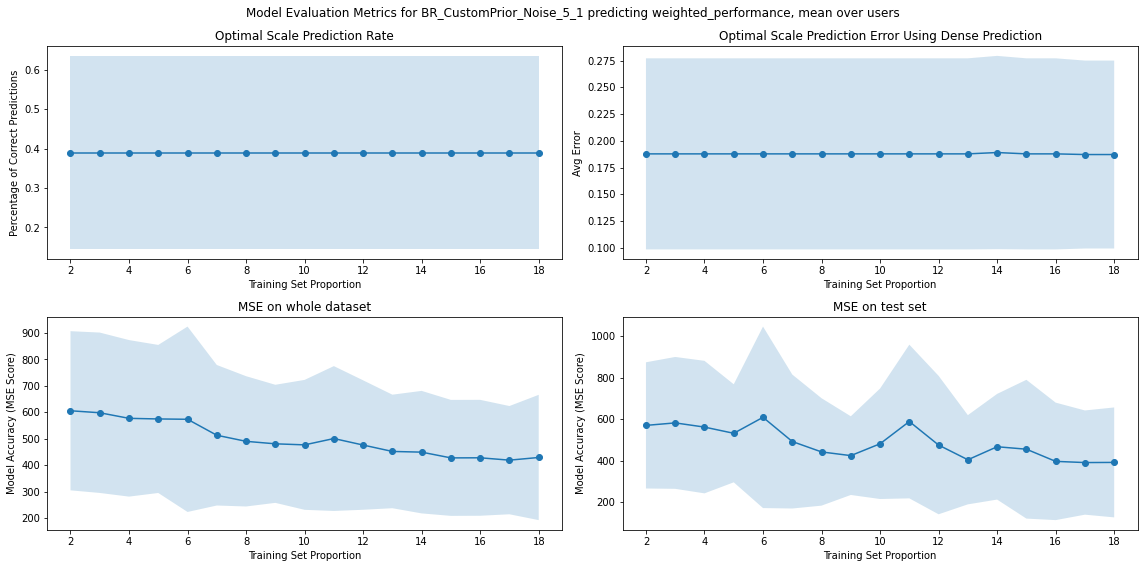

In [4]:
## Plot averaged results
import json

# Load data
## Choose model to apply, returning predictions over original dataset and dense inputs
# model_type = "Poly2"
# model_type = "GPR_RBF_default"
# model_type = "GPR_RBF_anisotropic"
# model_type = "GPR_RBF_Noise_default"
# model_type = "GPR_RBF_Noise_anisotropic"
# model_type = "GPR_RQ_default"
# model_type = "GPR_RQ_Noise_default"
model_type = "BR_CustomPrior_Noise_5_1"

with open(f"model_result_data/{model_type}.json", "r") as file:
	all_results = json.load(file)

print(all_results)
for output_metric, user_results in all_results.items():
	fig, axes = plt.subplots(2, 2, figsize=(16, 8))
	fig.suptitle(f"Model Evaluation Metrics for {model_type} predicting {output_metric}, mean over users")

	# Prepare lists of lists to store data
	match_rate_lists = []
	scale_error_lists = []
	full_mse_score_lists = []
	mse_score_lists = []
	n_train_lists = []

	# Collect data for each metric
	for user, results in user_results.items():
		match_rate_lists.append(results['match_rate'])
		scale_error_lists.append(results['scale_error'])
		full_mse_score_lists.append(results['full_mse_scores'])
		mse_score_lists.append(results['mse_scores'])
		n_train_lists.append(results['n_train_all'])

	# Function to calculate average and standard deviation safely
	def safe_mean_std(data_lists, index):
		valid_data = [data[index] for data in data_lists if index < len(data)]
		return np.mean(valid_data), np.std(valid_data)

	# Calculate averages and standard deviations safely
	avg_match_rate = []
	std_match_rate = []
	avg_scale_error = []
	std_scale_error = []
	avg_full_mse_scores = []
	std_full_mse_scores = []
	avg_mse_scores = []
	std_mse_scores = []

	min_n_train_length = min([len(data_list) for data_list in n_train_lists])
	min_n_train_list = n_train_lists[0][:min_n_train_length]
	for n in range(min_n_train_length):
		mean, std = safe_mean_std(match_rate_lists, n)
		avg_match_rate.append(mean)
		std_match_rate.append(std)

		mean, std = safe_mean_std(scale_error_lists, n)
		avg_scale_error.append(mean)
		std_scale_error.append(std)

		mean, std = safe_mean_std(full_mse_score_lists, n)
		avg_full_mse_scores.append(mean)
		std_full_mse_scores.append(std)

		mean, std = safe_mean_std(mse_score_lists, n)
		avg_mse_scores.append(mean)
		std_mse_scores.append(std)

	# Plotting the average values and standard deviation
	# Plotting the average values and standard deviation
	axes[0, 0].plot(min_n_train_list, avg_match_rate, marker='o', label='Mean over users')
	axes[0, 0].fill_between(min_n_train_list, np.subtract(avg_match_rate, std_match_rate), 
							np.add(avg_match_rate, std_match_rate), alpha=0.2)

	axes[0, 1].plot(min_n_train_list, avg_scale_error, marker='o', label='Mean over users')
	axes[0, 1].fill_between(min_n_train_list, np.subtract(avg_scale_error, std_scale_error), 
							np.add(avg_scale_error, std_scale_error), alpha=0.2)

	axes[1, 0].plot(min_n_train_list, avg_full_mse_scores, marker='o', label='Mean over users')
	axes[1, 0].fill_between(min_n_train_list, np.subtract(avg_full_mse_scores, std_full_mse_scores), 
							np.add(avg_full_mse_scores, std_full_mse_scores), alpha=0.2)

	axes[1, 1].plot(min_n_train_list, avg_mse_scores, marker='o', label='Mean Over Users')
	axes[1, 1].fill_between(min_n_train_list, np.subtract(avg_mse_scores, std_mse_scores), 
							np.add(avg_mse_scores, std_mse_scores), alpha=0.2)
	
	axes[0, 0].set_title("Optimal Scale Prediction Rate")
	axes[0, 0].set_xlabel("Training Set Proportion")
	axes[0, 0].set_ylabel("Percentage of Correct Predictions")

	axes[0, 1].set_title("Optimal Scale Prediction Error Using Dense Prediction")
	axes[0, 1].set_xlabel("Training Set Proportion")
	axes[0, 1].set_ylabel("Avg Error")


	axes[1, 0].set_title('MSE on whole dataset')
	axes[1, 0].set_xlabel('Training Set Proportion')
	axes[1, 0].set_ylabel('Model Accuracy (MSE Score)')

	axes[1, 1].set_title('MSE on test set')
	axes[1, 1].set_xlabel('Training Set Proportion')
	axes[1, 1].set_ylabel('Model Accuracy (MSE Score)')
	# axes[1, 0].legend()

	plt.tight_layout()
	plt.savefig(f"figures/model_results/{output_metric}/{model_type}_model_eval_metrics_{output_metric}_average.png", facecolor='w')
	plt.show()

In [ ]:
## Plot optimal scale


output_metrics = ["throughput", "avg_target_error", "avg_osd", "avg_movement_speed", "weighted_performance"]
for output_metric in output_metrics:
	# print(output_metric)
	user_results = {}
	plt.figure(figsize=(12, 6))
	for user, data in list(all_datasets.items()):

		if user == "user_lizzie" or user == "user_lizzie1":
			continue

		X = data[['latency', 'scale']]
		latency_range = np.arange(0.0, data['latency'].max()+0.01, 0.01)
		scale_range = np.linspace(data['scale'].min(), data['scale'].max(), 50)
		latency_grid, scale_grid = np.meshgrid(latency_range, scale_range)
		X_dense = np.c_[latency_grid.ravel(), scale_grid.ravel()]
		X_dense = np.round(X_dense, 3)

		## Choose model to apply, training on whole dataset, returning predictions over dense input
		# model_type = "GPR_RBF_default"
		# model_type = "GPR_RQ_default"
		# model_type = "Poly2"
		
		# # Polynomial Regression
		# degree = 2
		# Y_pred_dense = PolyRegression(X.values, Y.values, X_dense, degree)

		# Gaussian Process Regression
		# kernel = ConstantKernel() * RBF() # Default RBF
		# kernel = ConstantKernel() * RationalQuadratic() # Default Rational Quadratic
		# Y_pred_dense, Y_pred_std = GPRegression(X.values, Y.values, X_dense, kernel)

		# dense_df = pd.DataFrame({
		# 			'latency': X_dense[:, 0].flatten(),
		# 			'scale': X_dense[:, 1].flatten(),
		# 			'Y_pred_dense': Y_pred_dense.flatten()
		# 		})		

		if output_metric in ["throughput", "avg_movement_speed", "weighted_performance"]: # optimal scale at maximum
			# optimal_scale_dense = dense_df.loc[dense_df.groupby('latency')['Y_pred_dense'].idxmax()][['latency', 'scale']]
			optimal_scale_ref = data.loc[data.groupby('latency')[output_metric].idxmax()][['latency', 'scale']]
		else: # optimal scale at minimum
			# optimal_scale_dense = dense_df.loc[dense_df.groupby('latency')['Y_pred_dense'].idxmin()][['latency', 'scale']]
			optimal_scale_ref = data.loc[data.groupby('latency')[output_metric].idxmin()][['latency', 'scale']]

		# print(optimal_scale_ref)
		# plt.title(f"Optimal Scale by {output_metric}")
		plt.xlabel("latency")
		plt.ylabel("scaling factor")
		plt.plot(optimal_scale_ref['latency'], optimal_scale_ref['scale'], marker='x', label=user)
	plt.legend()
	plt.savefig(f"figures/optimal_scale_per_latency/{output_metric}.png", facecolor='w')
	plt.show()
		

In [ ]:
## Plot optimal scale per latency with model prediction

output_metrics = ["throughput", "avg_target_error", "avg_osd", "avg_movement_speed", "weighted_performance"]
for output_metric in output_metrics:
	# print(output_metric)
	user_results = {}
	plt.figure(figsize=(12, 6))
	for user, data in list(all_datasets.items())[:1]:

		if user == "user_lizzie" or user == "user_lizzie1":
			continue

		X = data[['latency', 'scale']]
		latency_range = np.arange(0.0, data['latency'].max()+0.01, 0.01)
		scale_range = np.linspace(data['scale'].min(), data['scale'].max(), 50)
		latency_grid, scale_grid = np.meshgrid(latency_range, scale_range)
		X_dense = np.c_[latency_grid.ravel(), scale_grid.ravel()]
		X_dense = np.round(X_dense, 3)

		## Choose model to apply, training on whole dataset, returning predictions over dense input
		# model_type = "GPR_RBF_default"
		model_type = "GPR_RQ_default"
		# model_type = "Poly2"
		
		# # Polynomial Regression
		# degree = 2
		# Y_pred_dense = PolyRegression(X.values, Y.values, X_dense, degree)

		# Gaussian Process Regression
		# kernel = ConstantKernel() * RBF() # Default RBF
		kernel = ConstantKernel() * RationalQuadratic() # Default Rational Quadratic
		Y_pred_dense, Y_pred_std = GPRegression(X.values, Y.values, X_dense, kernel)

		dense_df = pd.DataFrame({
					'latency': X_dense[:, 0].flatten(),
					'scale': X_dense[:, 1].flatten(),
					'Y_pred_dense': Y_pred_dense.flatten()
				})		
		

		if output_metric in ["throughput", "avg_movement_speed", "weighted_performance"]: # optimal scale at maximum
			optimal_scale_dense = dense_df.loc[dense_df.groupby('latency')['Y_pred_dense'].idxmax()][['latency', 'scale']]
			optimal_scale_ref = data.loc[data.groupby('latency')[output_metric].idxmax()][['latency', 'scale']]
		else: # optimal scale at minimum
			optimal_scale_dense = dense_df.loc[dense_df.groupby('latency')['Y_pred_dense'].idxmin()][['latency', 'scale']]
			optimal_scale_ref = data.loc[data.groupby('latency')[output_metric].idxmin()][['latency', 'scale']]

		# print(optimal_scale_ref)
		plt.title(f"Optimal Scale by {output_metric}")
		plt.xlabel("latency")
		plt.ylabel("scaling factor")
		plt.scatter(optimal_scale_ref['latency'], optimal_scale_ref['scale'], marker='x', label="measured")
		plt.plot(optimal_scale_dense['latency'], optimal_scale_dense['scale'], label="predicted")
	plt.legend()
	# plt.savefig(f"figures/optimal_scale_per_latency/{output_metric}.png")
	plt.show()

In [ ]:
## Plot key metric heatmaps for average over users
from utils import annotate_extrema

delete_keys = ["user_lizzie", "user_lizzie1", "user_lauren", "user_sarah1"]
sub_datasets = [all_datasets[key] for key in all_datasets.keys() if key not in delete_keys]

combined_df = pd.concat(sub_datasets)
averaged_df = combined_df.groupby(["latency", "scale"]).mean().reset_index()

# averaged_df = all_datasets["user_lizzie"]
# Create a 2x5 subplot for the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Plot the heatmap for throughput
heatmap_throughput = averaged_df.pivot(
    index='latency', columns='scale', values='throughput')
ax = sns.heatmap(heatmap_throughput, ax=axes[0], cmap="YlGnBu", annot=True, fmt='.3g')
axes[0].set_title('Throughput vs. Latency and Scale')
annotate_extrema(heatmap_throughput.values, ax)

# Plot heatmap for total error (target deviation + osd)
averaged_df['total_error'] = averaged_df['avg_osd'] + averaged_df['avg_target_error']
heatmap_error = averaged_df.pivot(
    index='latency', columns='scale', values='total_error')
ax = sns.heatmap(heatmap_error, ax=axes[1], cmap="YlGnBu", annot=True, fmt='.3g')
axes[1].set_title('Total Error vs. Latency and Scale')
annotate_extrema(heatmap_error.values, ax, extrema_type='min')

# Plot heatmap for combined performance (movement speed - total error)
heatmap_combo = averaged_df.pivot(
    index='latency', columns='scale', values='weighted_performance')
ax = sns.heatmap(heatmap_combo, ax=axes[2], cmap="YlGnBu", annot=True, fmt='.3g')
axes[2].set_title('Combined Performance vs. Latency and Scale')
annotate_extrema(heatmap_combo.values, ax, extrema_type='max')

# plt.title("User A")
plt.tight_layout()
# plt.savefig(f"{data_folder}/heatmap_key_metrics.png")
plt.show()

In [ ]:
# Define the function, e.g., a sine wave function
def smooth_2d_function(x, y):
    return np.sin(np.sqrt(x**2 + y**2))

# Generate sample points
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)
x, y = np.meshgrid(x, y)

# Apply the function to the sample points
z = smooth_2d_function(x, y)

# Create a DataFrame
df = pd.DataFrame({'x': x.ravel(), 'y': y.ravel(), 'z': z.ravel()})

X = df[['x', 'y']]
Y = df['z']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

z_pred, _ = GPRegression(X_train, Y_train, X)
z_pred = z_pred.reshape(x.shape)

# df["y_pred"] = Y_pred

# Plotting the function for visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

ax = axes[0].contourf(x, y, z, cmap='viridis')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Smooth 2D Function')

ax = axes[1].contourf(x, y, z_pred, cmap='viridis')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Predictions')

fig.colorbar(ax, label='Function Value')


In [ ]:
import pandas as pd

# Example dataframes
df1 = pd.DataFrame({'latency': [1, 2], 'scale': [3, 4], 'col1': [5, 6], 'col2': [7, 8]})
df2 = pd.DataFrame({'latency': [1, 2], 'scale': [3, 4], 'col1': [9, 10], 'col2': [11, 12]})

# Concatenating the dataframes
combined_df = pd.concat([df1, df2])
print(combined_df)
# Grouping by 'latency' and 'scale' and calculating the average of other columns
grouped_df = combined_df.groupby(['latency', 'scale'])['col1'].apply(list)

print(grouped_df)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_samples_with_noise(x_min, x_max, num_x, num_samples, noise_std):
    """
    Generates samples from a sine function with added Gaussian noise.

    Parameters:
    x_min (float): Minimum x value.
    x_max (float): Maximum x value.
    num_x (int): Number of distinct x values in the range.
    num_samples (int): Number of samples to generate for each x value.
    noise_std (float): Standard deviation of the Gaussian noise.

    Returns:
    None
    """
    # Generate x values
    x_values = np.linspace(x_min, x_max, num_x)

    # Plot the underlying sine function
    plt.plot(x_values, np.sin(x_values), label='Underlying sine function', color='blue')

    # Generate and plot samples with noise for each x value
    all_samples = []
    for x in x_values:
        noisy_samples = np.sin(x) + np.random.normal(0, noise_std, num_samples)
        plt.scatter([x]*num_samples, noisy_samples, color='red', alpha=0.5)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Samples from a Sine Function with Noise')
    plt.legend()
    plt.show()

# Example usage
generate_samples_with_noise(x_min=0, x_max=2*np.pi, num_x=30, num_samples=10, noise_std=0.2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from utils import annotate_extrema
from models import BayesRegression

### Modeling approach 2. Using Bayesian Regression, and all users as prior

# Separate datasets into one vs rest
user_to_remove = "user_jason"
one_user_data = all_datasets[user_to_remove]
sub_datasets = [all_datasets[key] for key in all_datasets.keys() if key != user_to_remove]
combined_df = pd.concat(sub_datasets)
averaged_df = combined_df.groupby(["latency", "scale"]).mean().reset_index()

# Perform Bayesian Regression on combined dataset
metric = 'throughput'
X = combined_df[['latency', 'scale']]
y = combined_df[metric]

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X.values)
# print(X_poly.shape)
# print(y.shape)

noise_std = 1
model = BayesRegression(X_poly.T, y, noise=noise_std)
weight_prior_mean, weight_prior_covar = model.fit()
# print(post_mean.shape, post_covar.shape)

latency_range = np.arange(0.0, combined_df['latency'].max()+0.01, 0.01)
scale_range = np.arange(combined_df['scale'].min(), combined_df['scale'].max()+0.025, 0.025) #np.linspace(data['scale'].min(), data['scale'].max(), 50)
latency_grid, scale_grid = np.meshgrid(latency_range, scale_range)
X_dense = np.c_[latency_grid.ravel(), scale_grid.ravel()]
X_dense = np.round(X_dense, 3)
X_dense_poly = poly.transform(X_dense)

# Y_pred, _ = model.predict(X_poly.T)
Y_pred_dense, _ = model.predict(X_dense_poly.T)
dense_df = pd.DataFrame({
					'latency': X_dense[:, 0].flatten(),
					'scale': X_dense[:, 1].flatten(),
					'Y_pred_dense': Y_pred_dense.flatten()
				})
# one_user_data["Y_pred"] = Y_pred

# utils.model_heatmaps(one_user_data, dense_df, X, 
# 					 user_to_remove, metric, 
# 					 "BayesRegression", post_mean.flatten())

if metric in ["throughput", "avg_movement_speed", "weighted_performance"]: 
        extrema_type = "max" # optimal scale at maximum
else:
	extrema_type = "min" # optimal scale at minimum
		
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
title = (f"Modeling all but one user")
fig.suptitle(title)

# Average over all but one user
averaged_data = averaged_df.pivot(
	index='latency', columns='scale', values=metric
)
sns.heatmap(averaged_data, cmap='YlGnBu', ax=ax[0], annot=True)
# annotate(ax[1], averaged_data, X_train, color='green')
ax[0].set_title('Average over all but one user')
ax[0].set_xlabel('Scale')
ax[0].set_ylabel('Latency')
annotate_extrema(averaged_data.values, ax[0], extrema_type)

dense_pred_data = dense_df.pivot(
	index='latency', columns='scale', values='Y_pred_dense'
)
sns.heatmap(dense_pred_data, cmap='YlGnBu', ax=ax[1])
# annotate(ax[1], dense_pred_data, X_train, color='green')
ax[1].set_title(f'Predicted Data over Dense Input\n{weight_prior_mean.flatten()}')
ax[1].set_xlabel('Scale')
ax[1].set_ylabel('Latency')
annotate_extrema(dense_pred_data.values, ax[1], extrema_type)

# # Plot residuals
# data["residual"] = np.abs(data["performance"] - data["Y_pred"])
# residual = data.pivot(
# 	index='latency', columns='scale', values='residual'
# )
# sns.heatmap(residual, cmap='YlGnBu', ax=ax[2], annot=True)
# annotate(ax[2], residual, X_train, color='green')
# ax[2].set_title('Residuals')
# ax[2].set_xlabel('Scale')
# ax[2].set_ylabel('Latency')
# annotate_extrema(residual.values, ax[2], 'min')

plt.tight_layout()
filepath = f"figures/allbutone_noise_{noise_std}.png"
plt.savefig(filepath, facecolor='w')
plt.show()
# plt.close()

## Use as prior for one user model
data = one_user_data
X = data[['latency', 'scale']]
Y = data[metric]

# Initialize evaluation metrics
optimal_match_rate = []
optimal_scale_error = []
mse_scores = []
full_mse_scores = []
n_train_mse = []
n_train_full_mse = []
n_train_p = []

n = len(data)
n_train_values = range(2, n-1)
for n_train in n_train_values:

	n_train_p.append(n_train / n)
	# Split into training/test sets
	# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=n_train/n)
	train_set, test_set = even_train_split(data, n_train)
	X_train, X_test = train_set[['latency', 'scale']], test_set[['latency', 'scale']]
	Y_train, Y_test = train_set[metric], test_set[metric]
	
	# Create dense test input
	# latency_set = data['latency'].unique()# np.arange(0.0, 0.76, 0.01)
	# latency_range = np.array(data['latency'].unique()) #np.linspace(latency_set.min(), latency_set.max(), 50)
	latency_range = np.arange(0.0, data['latency'].max()+0.01, 0.01)
	scale_range = np.arange(data['scale'].min(), data['scale'].max()+0.025, 0.025) #np.linspace(data['scale'].min(), data['scale'].max(), 50)
	latency_grid, scale_grid = np.meshgrid(latency_range, scale_range)
	X_dense = np.c_[latency_grid.ravel(), scale_grid.ravel()]
	X_dense = np.round(X_dense, 3)

	poly = PolynomialFeatures(degree=2)
	X_poly = poly.fit_transform(X.values)
	X_train_poly = poly.transform(X_train.values)
	X_test_poly = poly.transform(X_test.values)
	X_dense_poly = poly.transform(X_dense)
	
	# Train model
	model = BayesRegression(X_train_poly.T, Y_train, noise_std)
	model.set_prior(weight_prior_mean, weight_prior_covar)
	post_mean, post_covar = model.fit()

	# Predict
	Y_pred, _ = model.predict(X_poly.T)
	Y_pred_dense, _ = model.predict(X_dense_poly.T)

	## Evaluate metrics
	dense_df = pd.DataFrame({
			'latency': X_dense[:, 0].flatten(),
			'scale': X_dense[:, 1].flatten(),
			'Y_pred_dense': Y_pred_dense.flatten()
		})
	data["Y_pred"] = Y_pred

	# Mean Square Error on whole dataset
	full_mse = mean_squared_error(Y, Y_pred)
	if True: #full_mse < 5000:
		n_train_full_mse.append(n_train)
		full_mse_scores.append(full_mse)

	# Mean Square Error on test set
	Y_test_pred = data.loc[Y_test.index]["Y_pred"]
	mse = mean_squared_error(Y_test, Y_test_pred)
	if True: #mse < 5000:
		n_train_mse.append(n_train)
		mse_scores.append(mse)
	
	if metric in ["throughput", "avg_movement_speed", "weighted_performance"]: # optimal scale at maximum
		optimal_scale_dense = dense_df.loc[dense_df.groupby('latency')['Y_pred_dense'].idxmax()][['latency', 'scale']]
		optimal_scale_ref = data.loc[data.groupby('latency')[metric].idxmax()][['latency', 'scale']]
		optimal_scale_pred = data.loc[data.groupby('latency')['Y_pred'].idxmax()][['latency', 'scale']]
	else: # optimal scale at minimum
		optimal_scale_dense = dense_df.loc[dense_df.groupby('latency')['Y_pred_dense'].idxmin()][['latency', 'scale']]
		optimal_scale_ref = data.loc[data.groupby('latency')[metric].idxmin()][['latency', 'scale']]
		optimal_scale_pred = data.loc[data.groupby('latency')['Y_pred'].idxmin()][['latency', 'scale']]

	# Merge the results on 'latency'
	merged_ref_pred = pd.merge(optimal_scale_ref, optimal_scale_pred, 
						on='latency', suffixes=('_ref', '_pred'))
	
	merged_ref_dense = pd.merge(optimal_scale_ref, optimal_scale_dense, 
						on='latency', suffixes=('_ref', '_dense'))
	# print(optimal_scale_dense)
	# print(merged_ref_dense)
	

	# Count the number of matches
	matches = (merged_ref_pred['scale_ref'] == merged_ref_pred['scale_pred']).sum()
	scale_error = np.abs(merged_ref_dense['scale_ref'] - merged_ref_dense['scale_dense']).mean()

	optimal_match_rate.append(matches / len(optimal_scale_ref))
	optimal_scale_error.append(scale_error)

	# Visualize model prediction
	if n_train == n-2:
		utils.model_heatmaps(data, dense_df, X_train, user_to_remove, metric, "BayesRegressionwithPrior", post_mean.flatten())



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from models import BayesRegression


### Generate example linear dataset

# Parameters for the linear relationship
a = 2  # slope
b = 3  # intercept
c = 1
noise_std = 30 # standard deviation of the noise

np.random.seed(0)  # for reproducibility
X = np.linspace(-5, 5, 100)
y = []

# Generating Y values with noise
X_full = []
y_full = []
for x_val in X:
	y_val = a * x_val**2 + b * x_val + c
	y.append(y_val)
	X_full += [x_val for i in range(10)]
	y_noisy = y_val + np.random.normal(0, noise_std, 10)
	y_full += list(y_noisy)

X_full = np.array(X_full)
y_full = np.array(y_full)
# Creating a DataFrame
dataset = pd.DataFrame({'X': X, 'y': y})

X_homo = X.reshape((1, -1))
X_homo = np.vstack((X_homo, np.ones(X_homo.shape)))

poly = PolynomialFeatures(degree=2)
# print(X.shape)
X_poly = poly.fit_transform(X_full.reshape(-1, 1))
# print(X_poly.shape)
# print(X_poly[1,:])
# print(y.shape)
model = BayesRegression(X_poly.T, y_full, noise=1000)
model.set_prior(np.array([1, 3, 2]), 0.0001)
post_mean, post_covar = model.fit()
# print(post_mean)
# print(post_covar)

# Test inputs
test_input = np.arange(-5, 6, 1).reshape(-1, 1)
test_input_poly = poly.transform(test_input)
# print(test_input_poly.shape)
# test_input_homo = np.vstack((test_input, np.ones(test_input.shape)))
pred_mean, pred_covar = model.predict(test_input_poly.T)
# print(pred_mean)
# print(pred_covar.shape)

# print(X.shape, y.shape, y_noisy.shape)
plt.scatter(X_full, y_full, marker='x')
plt.plot(X, y, linestyle='--', color='black')
plt.scatter(test_input, pred_mean, color='red')
plt.show()

In [ ]:


## Choose model to apply, returning predictions over original dataset and dense inputs
# model_type = "Poly2"
# model_type = "GPR_RBF_default"
# model_type = "GPR_RBF_anisotropic"
# model_type = "GPR_RBF_Noise_default"
# model_type = "GPR_RBF_Noise_anisotropic"
# model_type = "GPR_RQ_default"
# model_type = "GPR_RQ_Noise_default"
model_type = "BR_CustomPrior_Noise_5_1"

prior_noise_std = 5
model = BayesRegression(X_poly.T, y, noise=prior_noise_std)
weight_prior_mean, weight_prior_covar = model.fit()
# print(post_mean.shape, post_covar.shape)

latency_range = np.arange(0.0, combined_df['latency'].max()+0.01, 0.01)
scale_range = np.arange(combined_df['scale'].min(), combined_df['scale'].max()+0.025, 0.025) #np.linspace(data['scale'].min(), data['scale'].max(), 50)
latency_grid, scale_grid = np.meshgrid(latency_range, scale_range)
X_dense = np.c_[latency_grid.ravel(), scale_grid.ravel()]
X_dense = np.round(X_dense, 3)
X_dense_poly = poly.transform(X_dense)

# Y_pred, _ = model.predict(X_poly.T)
Y_pred_dense, _ = model.predict(X_dense_poly.T)
dense_df = pd.DataFrame({
					'latency': X_dense[:, 0].flatten(),
					'scale': X_dense[:, 1].flatten(),
					'Y_pred_dense': Y_pred_dense.flatten()
				})
# one_user_data["Y_pred"] = Y_pred

# utils.model_heatmaps(one_user_data, dense_df, X, 
# 					 user_to_remove, metric, 
# 					 "BayesRegression", post_mean.flatten())

if metric in ["throughput", "avg_movement_speed", "weighted_performance"]: 
		extrema_type = "max" # optimal scale at maximum
else:
	extrema_type = "min" # optimal scale at minimum
		
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
title = (f"Modeling all but {user}")
fig.suptitle(title)

# Average over all but one user
averaged_data = averaged_df.pivot(
	index='latency', columns='scale', values=metric
)
sns.heatmap(averaged_data, cmap='YlGnBu', ax=ax[0], annot=True)
# annotate(ax[1], averaged_data, X_train, color='green')
ax[0].set_title('Average')
ax[0].set_xlabel('Scale')
ax[0].set_ylabel('Latency')
annotate_extrema(averaged_data.values, ax[0], extrema_type)

dense_pred_data = dense_df.pivot(
	index='latency', columns='scale', values='Y_pred_dense'
)
sns.heatmap(dense_pred_data, cmap='YlGnBu', ax=ax[1])
# annotate(ax[1], dense_pred_data, X_train, color='green')
ax[1].set_title(("Predicted Data over Dense Input." 
					f"Likelihood Noise {prior_noise_std}\n"
					f"Coef: {weight_prior_mean.flatten()}"))
ax[1].set_xlabel('Scale')
ax[1].set_ylabel('Latency')
annotate_extrema(dense_pred_data.values, ax[1], extrema_type)

# # Plot residuals
# data["residual"] = np.abs(data["performance"] - data["Y_pred"])
# residual = data.pivot(
# 	index='latency', columns='scale', values='residual'
# )
# sns.heatmap(residual, cmap='YlGnBu', ax=ax[2], annot=True)
# annotate(ax[2], residual, X_train, color='green')
# ax[2].set_title('Residuals')
# ax[2].set_xlabel('Scale')
# ax[2].set_ylabel('Latency')
# annotate_extrema(residual.values, ax[2], 'min')

plt.tight_layout()
filepath = f"figures/allbutone/noise_{prior_noise_std}/{metric}_{user}.png"
plt.savefig(filepath, facecolor='w')
# plt.show()

# Now perform Bayesian Regression for one user, using prior from other users
# Prepare data 
X = data[['latency', 'scale']]
Y = data[metric]

# Initialize evaluation metrics
optimal_match_rate = []
optimal_scale_error = []
mse_scores = []
full_mse_scores = []
n_train_mse = []
n_train_full_mse = []
n_train_p = []

n = len(data)
n_train_values = range(2, n-1)
for n_train in n_train_values:

	n_train_p.append(n_train / n)
	# Split into training/test sets
	# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=n_train/n)
	train_set, test_set = even_train_split(data, n_train)
	X_train, X_test = train_set[['latency', 'scale']], test_set[['latency', 'scale']]
	Y_train, Y_test = train_set[metric], test_set[metric]
	
	# Create dense test input
	# latency_set = data['latency'].unique()# np.arange(0.0, 0.76, 0.01)
	# latency_range = np.array(data['latency'].unique()) #np.linspace(latency_set.min(), latency_set.max(), 50)
	latency_range = np.arange(0.0, data['latency'].max()+0.01, 0.01)
	scale_range = np.arange(data['scale'].min(), data['scale'].max()+0.025, 0.025) #np.linspace(data['scale'].min(), data['scale'].max(), 50)
	latency_grid, scale_grid = np.meshgrid(latency_range, scale_range)
	X_dense = np.c_[latency_grid.ravel(), scale_grid.ravel()]
	X_dense = np.round(X_dense, 3)
		
	if model_type.startswith("BR"):
		poly = PolynomialFeatures(degree=2)
		X_poly = poly.fit_transform(X.values)
		X_train_poly = poly.transform(X_train.values)
		X_test_poly = poly.transform(X_test.values)
		X_dense_poly = poly.transform(X_dense)
		
		# Train model
		noise_std = 1
		model = BayesRegression(X_train_poly.T, Y_train, noise=noise_std)
		model.set_prior(weight_prior_mean, weight_prior_covar)
		post_mean, post_covar = model.fit()
		model_params = f"likelihood noise: {noise_std}, coef: {post_mean.flatten()}"
		# Predict
		Y_pred, _ = model.predict(X_poly.T)
		Y_pred_dense, _ = model.predict(X_dense_poly.T)
	else:
		print("Invalid kernel specification!")
		break

	## Evaluate metrics
	dense_df = pd.DataFrame({
			'latency': X_dense[:, 0].flatten(),
			'scale': X_dense[:, 1].flatten(),
			'Y_pred_dense': Y_pred_dense.flatten()
		})
	data["Y_pred"] = Y_pred

	# Mean Square Error on whole dataset
	full_mse = mean_squared_error(Y, Y_pred)
	if True: #full_mse < 5000:
		n_train_full_mse.append(n_train)
		full_mse_scores.append(full_mse)

	# Mean Square Error on test set
	Y_test_pred = data.loc[Y_test.index]["Y_pred"]
	mse = mean_squared_error(Y_test, Y_test_pred)
	if True: #mse < 5000:
		n_train_mse.append(n_train)
		mse_scores.append(mse)
	
	if metric in ["throughput", "avg_movement_speed", "weighted_performance"]: # optimal scale at maximum
		optimal_scale_dense = dense_df.loc[dense_df.groupby('latency')['Y_pred_dense'].idxmax()][['latency', 'scale']]
		optimal_scale_ref = data.loc[data.groupby('latency')[metric].idxmax()][['latency', 'scale']]
		optimal_scale_pred = data.loc[data.groupby('latency')['Y_pred'].idxmax()][['latency', 'scale']]
	else: # optimal scale at minimum
		optimal_scale_dense = dense_df.loc[dense_df.groupby('latency')['Y_pred_dense'].idxmin()][['latency', 'scale']]
		optimal_scale_ref = data.loc[data.groupby('latency')[metric].idxmin()][['latency', 'scale']]
		optimal_scale_pred = data.loc[data.groupby('latency')['Y_pred'].idxmin()][['latency', 'scale']]

	# Merge the results on 'latency'
	merged_ref_pred = pd.merge(optimal_scale_ref, optimal_scale_pred, 
						on='latency', suffixes=('_ref', '_pred'))
	
	merged_ref_dense = pd.merge(optimal_scale_ref, optimal_scale_dense, 
						on='latency', suffixes=('_ref', '_dense'))
	# print(optimal_scale_dense)
	# print(merged_ref_dense)
	

	# Count the number of matches
	matches = (merged_ref_pred['scale_ref'] == merged_ref_pred['scale_pred']).sum()
	scale_error = np.abs(merged_ref_dense['scale_ref'] - merged_ref_dense['scale_dense']).mean()

	optimal_match_rate.append(matches / len(optimal_scale_ref))
	optimal_scale_error.append(scale_error)

	# Visualize model prediction
	if n_train == n-2:
		model_heatmaps(data, dense_df, X_train, user, metric, model_type, model_params)

	else:
		# Store results from this dataset
		user_results[user] = {
			'n_train_mse': list(n_train_mse),
			'n_train_full_mse': list(n_train_full_mse),
			'full_mse_scores': full_mse_scores,
			'mse_scores': mse_scores,
			'n_train_all': list(n_train_values),
			'match_rate': optimal_match_rate,
			'scale_error': optimal_scale_error,
			'n_train_p': n_train_p
		}
		continue
	break	
else:
	# print(f"saving {metric} to all_results")
	all_results[metric] = user_results
	continue
break

# print(all_results.keys())
with open(f"model_result_data/{model_type}.json", "w") as file:
	json.dump(all_results, file)
# with open(f"model_result_data/{model_type}.json", "r") as file:
# 	og_results = json.load(file)

# og_results["total_error"] = all_results["total_error"]

# with open(f"model_result_data/{model_type}.json", "w") as file:
# 	json.dump(og_results, file)
# print("T-statistic:", t_statistic)
# print("P-value:", p_value)

# # Interpret the p-value
# alpha = 0.05  # commonly used threshold for significance
# if p_value < alpha:
#     print("There is a significant difference.")
# else:
#     print("There is no significant difference.")


In [ ]:
### Stats test
import numpy as np
from scipy.stats import ttest_rel

# Prepare data
users_to_remove = ["user_lauren", "user_lizzie", "user_lizzie1", "user_sarah1", "user_lizzie2"]
all_data_list = [all_datasets[user] for user in all_datasets.keys() if user not in users_to_remove]
# print(len(all_data_list))
combined_df = pd.concat(all_data_list)
grouped_df = combined_df.groupby(["latency", "scale"])
TP_group = grouped_df["throughput"].apply(list)

# Group by 'latency'
grouped_by_latency = combined_df.groupby('latency')
pvals = {}
scales = {}
# Iterate over each latency group
metric = "weighted_performance"
alternative_hyp = "greater"
for l, (latency, latency_group) in enumerate(grouped_by_latency):
	print(f"Latency: {latency}")

	# Within each latency group, further group by 'scale'
	grouped_by_scale = latency_group.groupby('scale')
	baseline = list(grouped_by_scale.get_group(1.0)[metric])
	print(baseline)
	pvals[latency] = []
	scales[latency] = []
	# Iterate over each scale group within the current latency group
	for s, (scale, scale_group) in enumerate(grouped_by_scale):
		values = list(scale_group[metric])
		if len(values) == 5 and scale != 1.0:
			print(f"comparing scale {scale} against baseline")
			print(f"  Scale: {scale}, Values: {list(scale_group[metric])}")
			t_statistic, p_value = ttest_rel(values, baseline, alternative=alternative_hyp)
			pvals[latency].append(p_value)
			scales[latency].append(scale)
			print(p_value)


plt.figure()
for latency, p_values in pvals.items():
	plt.plot(scales[latency], p_values, marker='o', label=f"{latency} s")

# plt.title(f"Paired-Sample T Test Comparing {metric}, Alternative Hypothesis: {alternative_hyp}")
plt.axhline(0.05, color="black", linestyle='--')
plt.xlabel("scaling factor")
plt.ylabel("p value")
plt.legend()
plt.tight_layout()
plt.savefig(f"figures/stat_tests/{metric}_{alternative_hyp}.png", facecolor='w')
plt.show()

# print(TP_group)
# p_vals = {}
# baseline = TP_group[(0.0, 1.0)]
# test = TP_group[(0.0, 0.15)]
# print(baseline)
# print(test)
# t_stat, p_val = ttest_rel(baseline, test)
# print(p_val)
# for params, values in TP_group.items():
# 	# print(f"Latency: {latency}, Scale: {scale}, Values: {len(list(throughput))}")
# 	if len(values) == 6

# # Example data: before and after treatment
# data_before = np.array([20, 21, 19, 22, 20, 23, 21])
# data_after = np.array([22, 22, 20, 23, 21, 24, 22])

# # Perform the paired t-test
# t_statistic, p_value = ttest_rel(data_before, data_after)

In [ ]:
### All vs. one Bayesian Regression
from models import PolyRegression, GPRegression, BayesRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, RationalQuadratic, WhiteKernel
from utils import annotate_extrema, model_heatmaps
import json
import warnings
import logging

## Choose model to apply, returning predictions over original dataset and dense inputs
# model_type = "Poly2"
# model_type = "GPR_RBF_default"
# model_type = "GPR_RBF_anisotropic"
# model_type = "GPR_RBF_Noise_default"
# model_type = "GPR_RBF_Noise_anisotropic"
# model_type = "GPR_RQ_default"
# model_type = "GPR_RQ_Noise_default"
model_type = "BR_CustomPrior_Noise_1_001"

# Configure logging to write to a file
logging.basicConfig(filename='warnings_log.txt', level=logging.WARNING, format='%(message)s')

# Function to redirect warnings to logging
def warn_to_logging(message, category, filename, lineno, file=None, line=None):
    logging.warning(f'{filename}:{lineno}: {category.__name__}: {message}')

# Redirect all warnings to the warn_to_logging function
warnings.showwarning = warn_to_logging

all_results = {}
output_metrics = ["throughput", "avg_target_error", "avg_osd", "avg_movement_speed", "total_error", "weighted_performance"]
for metric in output_metrics:
	
	print(metric)
	user_results = {}
	for user, data in list(all_datasets.items()): 

		# if user == "user_lizzie" or user == "user_lizzie1":
		# 	continue
		print(f"\t{user}")

		sub_datasets = [all_datasets[key] for key in all_datasets.keys() if key != user]
		combined_df = pd.concat(sub_datasets)
		averaged_df = combined_df.groupby(["latency", "scale"]).mean().reset_index()

		# Perform Bayesian Regression on combined dataset
		X = combined_df[['latency', 'scale']]
		y = combined_df[metric]

		poly = PolynomialFeatures(degree=2)
		X_poly = poly.fit_transform(X.values)
		# print(X_poly.shape)
		# print(y.shape)

		prior_noise_std = 1
		model = BayesRegression(X_poly.T, y, noise=prior_noise_std)
		weight_prior_mean, weight_prior_covar = model.fit()
		# print(post_mean.shape, post_covar.shape)

		latency_range = np.arange(0.0, combined_df['latency'].max()+0.01, 0.01)
		scale_range = np.arange(combined_df['scale'].min(), combined_df['scale'].max()+0.025, 0.025) #np.linspace(data['scale'].min(), data['scale'].max(), 50)
		latency_grid, scale_grid = np.meshgrid(latency_range, scale_range)
		X_dense = np.c_[latency_grid.ravel(), scale_grid.ravel()]
		X_dense = np.round(X_dense, 3)
		X_dense_poly = poly.transform(X_dense)

		# Y_pred, _ = model.predict(X_poly.T)
		Y_pred_dense, _ = model.predict(X_dense_poly.T)
		dense_df = pd.DataFrame({
							'latency': X_dense[:, 0].flatten(),
							'scale': X_dense[:, 1].flatten(),
							'Y_pred_dense': Y_pred_dense.flatten()
						})
		# one_user_data["Y_pred"] = Y_pred

		# utils.model_heatmaps(one_user_data, dense_df, X, 
		# 					 user_to_remove, metric, 
		# 					 "BayesRegression", post_mean.flatten())

		if metric in ["throughput", "avg_movement_speed", "weighted_performance"]: 
				extrema_type = "max" # optimal scale at maximum
		else:
			extrema_type = "min" # optimal scale at minimum
				
		fig, ax = plt.subplots(1, 2, figsize=(18, 6))
		title = (f"Modeling all but {user}")
		fig.suptitle(title)

		# Average over all but one user
		averaged_data = averaged_df.pivot(
			index='latency', columns='scale', values=metric
		)
		sns.heatmap(averaged_data, cmap='YlGnBu', ax=ax[0], annot=True)
		# annotate(ax[1], averaged_data, X_train, color='green')
		ax[0].set_title('Average')
		ax[0].set_xlabel('Scale')
		ax[0].set_ylabel('Latency')
		annotate_extrema(averaged_data.values, ax[0], extrema_type)

		dense_pred_data = dense_df.pivot(
			index='latency', columns='scale', values='Y_pred_dense'
		)
		sns.heatmap(dense_pred_data, cmap='YlGnBu', ax=ax[1])
		# annotate(ax[1], dense_pred_data, X_train, color='green')
		ax[1].set_title(f'Predicted Data over Dense Input\n{weight_prior_mean.flatten()}')
		ax[1].set_xlabel('Scale')
		ax[1].set_ylabel('Latency')
		annotate_extrema(dense_pred_data.values, ax[1], extrema_type)

		# # Plot residuals
		# data["residual"] = np.abs(data["performance"] - data["Y_pred"])
		# residual = data.pivot(
		# 	index='latency', columns='scale', values='residual'
		# )
		# sns.heatmap(residual, cmap='YlGnBu', ax=ax[2], annot=True)
		# annotate(ax[2], residual, X_train, color='green')
		# ax[2].set_title('Residuals')
		# ax[2].set_xlabel('Scale')
		# ax[2].set_ylabel('Latency')
		# annotate_extrema(residual.values, ax[2], 'min')

		plt.tight_layout()
		filepath = f"figures/allbutone/{metric}_{user}_noise_{prior_noise_std}.png"
		plt.savefig(filepath, facecolor='w')
		# plt.show()

		# Now perform Bayesian Regression for one user, using prior from other users
		# Prepare data 
		X = data[['latency', 'scale']]
		Y = data[metric]

		# Initialize evaluation metrics
		optimal_match_rate = []
		optimal_scale_error = []
		mse_scores = []
		full_mse_scores = []
		n_train_mse = []
		n_train_full_mse = []
		n_train_p = []

		n = len(data)
		n_train_values = range(2, n-1)
		for n_train in n_train_values:

			n_train_p.append(n_train / n)
			# Split into training/test sets
			# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=n_train/n)
			train_set, test_set = even_train_split(data, n_train)
			X_train, X_test = train_set[['latency', 'scale']], test_set[['latency', 'scale']]
			Y_train, Y_test = train_set[metric], test_set[metric]
			
			# Create dense test input
			# latency_set = data['latency'].unique()# np.arange(0.0, 0.76, 0.01)
			# latency_range = np.array(data['latency'].unique()) #np.linspace(latency_set.min(), latency_set.max(), 50)
			latency_range = np.arange(0.0, data['latency'].max()+0.01, 0.01)
			scale_range = np.arange(data['scale'].min(), data['scale'].max()+0.025, 0.025) #np.linspace(data['scale'].min(), data['scale'].max(), 50)
			latency_grid, scale_grid = np.meshgrid(latency_range, scale_range)
			X_dense = np.c_[latency_grid.ravel(), scale_grid.ravel()]
			X_dense = np.round(X_dense, 3)
				
			if model_type.startswith("BR"):
				poly = PolynomialFeatures(degree=2)
				X_poly = poly.fit_transform(X.values)
				X_train_poly = poly.transform(X_train.values)
				X_test_poly = poly.transform(X_test.values)
				X_dense_poly = poly.transform(X_dense)
				
				# Train model
				noise_std = 0.001
				model = BayesRegression(X_train_poly.T, Y_train, noise=noise_std)
				model.set_prior(weight_prior_mean, weight_prior_covar)
				post_mean, post_covar = model.fit()
				model_params = f"noise: {noise_std}, coef: {post_mean.flatten()}"
				# Predict
				Y_pred, _ = model.predict(X_poly.T)
				Y_pred_dense, _ = model.predict(X_dense_poly.T)
			else:
				print("Invalid kernel specification!")
				break

			## Evaluate metrics
			dense_df = pd.DataFrame({
					'latency': X_dense[:, 0].flatten(),
					'scale': X_dense[:, 1].flatten(),
					'Y_pred_dense': Y_pred_dense.flatten()
				})
			data["Y_pred"] = Y_pred

			# Mean Square Error on whole dataset
			full_mse = mean_squared_error(Y, Y_pred)
			if True: #full_mse < 5000:
				n_train_full_mse.append(n_train)
				full_mse_scores.append(full_mse)

			# Mean Square Error on test set
			Y_test_pred = data.loc[Y_test.index]["Y_pred"]
			mse = mean_squared_error(Y_test, Y_test_pred)
			if True: #mse < 5000:
				n_train_mse.append(n_train)
				mse_scores.append(mse)
			
			if metric in ["throughput", "avg_movement_speed", "weighted_performance"]: # optimal scale at maximum
				optimal_scale_dense = dense_df.loc[dense_df.groupby('latency')['Y_pred_dense'].idxmax()][['latency', 'scale']]
				optimal_scale_ref = data.loc[data.groupby('latency')[metric].idxmax()][['latency', 'scale']]
				optimal_scale_pred = data.loc[data.groupby('latency')['Y_pred'].idxmax()][['latency', 'scale']]
			else: # optimal scale at minimum
				optimal_scale_dense = dense_df.loc[dense_df.groupby('latency')['Y_pred_dense'].idxmin()][['latency', 'scale']]
				optimal_scale_ref = data.loc[data.groupby('latency')[metric].idxmin()][['latency', 'scale']]
				optimal_scale_pred = data.loc[data.groupby('latency')['Y_pred'].idxmin()][['latency', 'scale']]

			# Merge the results on 'latency'
			merged_ref_pred = pd.merge(optimal_scale_ref, optimal_scale_pred, 
								on='latency', suffixes=('_ref', '_pred'))
			
			merged_ref_dense = pd.merge(optimal_scale_ref, optimal_scale_dense, 
								on='latency', suffixes=('_ref', '_dense'))
			# print(optimal_scale_dense)
			# print(merged_ref_dense)
			

			# Count the number of matches
			matches = (merged_ref_pred['scale_ref'] == merged_ref_pred['scale_pred']).sum()
			scale_error = np.abs(merged_ref_dense['scale_ref'] - merged_ref_dense['scale_dense']).mean()

			optimal_match_rate.append(matches / len(optimal_scale_ref))
			optimal_scale_error.append(scale_error)

			# Visualize model prediction
			if n_train == n-2:
				model_heatmaps(data, dense_df, X_train, user, metric, model_type, model_params)

		else:
			# Store results from this dataset
			user_results[user] = {
				'n_train_mse': list(n_train_mse),
				'n_train_full_mse': list(n_train_full_mse),
				'full_mse_scores': full_mse_scores,
				'mse_scores': mse_scores,
				'n_train_all': list(n_train_values),
				'match_rate': optimal_match_rate,
				'scale_error': optimal_scale_error,
				'n_train_p': n_train_p
			}
			continue
		break	
	else:
		# print(f"saving {metric} to all_results")
		all_results[metric] = user_results
		continue
	break

# print(all_results.keys())
with open(f"model_result_data/{model_type}.json", "w") as file:
	json.dump(all_results, file)
# with open(f"model_result_data/{model_type}.json", "r") as file:
# 	og_results = json.load(file)

# og_results["total_error"] = all_results["total_error"]

# with open(f"model_result_data/{model_type}.json", "w") as file:
# 	json.dump(og_results, file)

In [5]:
### Demographic Analysis
# M vs F t test
male_users = ["user_jason", "user_sujaan", "user_xiao", "user_yutong"]
female_users = ["user_shreya", "user_lauren", "user_lizzie2", "user_sarah1"]
male_combined = pd.concat([all_datasets[user] for user in male_users])
female_combined = pd.concat([all_datasets[user] for user in female_users])
male_users

p_vals = {}

for latency, latency_group in male_users.groupby("latency"):
	print(f"Latency: {latency}")

	# Within each latency group, further group by 'scale'
	grouped_by_scale = latency_group.groupby('scale')
	baseline = list(grouped_by_scale.get_group(1.0)[metric])
	print(baseline)
	pvals[latency] = []
	scales[latency] = []
	# Iterate over each scale group within the current latency group
	for s, (scale, scale_group) in enumerate(grouped_by_scale):
		values = list(scale_group[metric])
		
		print(f"comparing scale {scale} against baseline")
		print(f"  Scale: {scale}, Values: {list(scale_group[metric])}")
		t_statistic, p_value = ttest_rel(values, baseline, alternative=alternative_hyp)
		pvals[latency].append(p_value)
		scales[latency].append(scale)
		print(p_value)



TypeError: unhashable type: 'list'